In [31]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Prepare Data

In [32]:
cloud_cover = pd.read_csv('Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv',skipinitialspace = True)
cloud_cover.isnull().sum()

Year          0
Month         0
Day           0
Hour          0
Minute        0
Second        0
CloudCover    0
dtype: int64

In [33]:
cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)     
cloud_cover

,CloudCover,Date,Time
0,0.990,2021-11-16,11:15
1,0.989,2021-11-16,11:16
2,0.989,2021-11-16,11:16
3,0.988,2021-11-16,11:17
4,0.988,2021-11-16,11:17
...,...,...,...
22021,0.168,2021-12-16,13:58
22022,0.169,2021-12-16,13:59
22023,0.147,2021-12-16,14:00
22024,0.145,2021-12-16,14:01


In [34]:
cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
cloud_cover

,cloud_cover,DateTime
0,0.990000,2021-11-16 11:15:00
1,0.989000,2021-11-16 11:16:00
2,0.987667,2021-11-16 11:17:00
3,0.987000,2021-11-16 11:18:00
4,0.987000,2021-11-16 11:19:00
...,...,...
15056,0.168000,2021-12-16 13:58:00
15057,0.169000,2021-12-16 13:59:00
15058,0.147000,2021-12-16 14:00:00
15059,0.145000,2021-12-16 14:01:00


In [35]:
cloud_cover.dropna(inplace=True)
cloud_cover

,cloud_cover,DateTime
0,0.990000,2021-11-16 11:15:00
1,0.989000,2021-11-16 11:16:00
2,0.987667,2021-11-16 11:17:00
3,0.987000,2021-11-16 11:18:00
4,0.987000,2021-11-16 11:19:00
...,...,...
15056,0.168000,2021-12-16 13:58:00
15057,0.169000,2021-12-16 13:59:00
15058,0.147000,2021-12-16 14:00:00
15059,0.145000,2021-12-16 14:01:00


### Outlier

<AxesSubplot: >

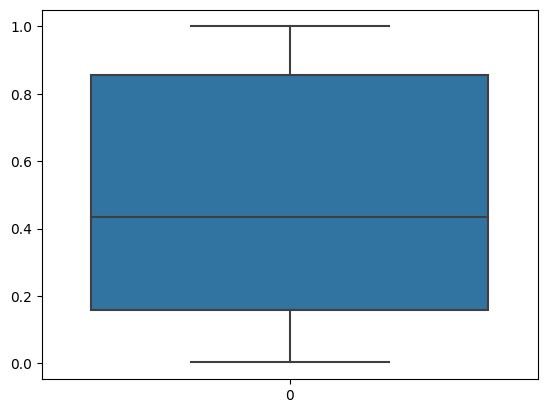

In [36]:
sns.boxplot(cloud_cover['cloud_cover'])

In [37]:
df = cloud_cover[['DateTime', 'cloud_cover']]
df.columns = ['ds', 'y']
df

,ds,y
0,2021-11-16 11:15:00,0.990000
1,2021-11-16 11:16:00,0.989000
2,2021-11-16 11:17:00,0.987667
3,2021-11-16 11:18:00,0.987000
4,2021-11-16 11:19:00,0.987000
...,...,...
15056,2021-12-16 13:58:00,0.168000
15057,2021-12-16 13:59:00,0.169000
15058,2021-12-16 14:00:00,0.147000
15059,2021-12-16 14:01:00,0.145000


### Train/Test Model

In [38]:
X_train = df.iloc[len(df) - 60:len(df) - 30]
X_test = df.iloc[len(df) - 30:]

print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_train['ds'].unique()

X_train Shape (30, 2)
X_test Shape (30, 2)


array(['2021-12-16T13:03:00.000000000', '2021-12-16T13:04:00.000000000',
       '2021-12-16T13:05:00.000000000', '2021-12-16T13:06:00.000000000',
       '2021-12-16T13:07:00.000000000', '2021-12-16T13:08:00.000000000',
       '2021-12-16T13:09:00.000000000', '2021-12-16T13:10:00.000000000',
       '2021-12-16T13:11:00.000000000', '2021-12-16T13:12:00.000000000',
       '2021-12-16T13:13:00.000000000', '2021-12-16T13:14:00.000000000',
       '2021-12-16T13:15:00.000000000', '2021-12-16T13:16:00.000000000',
       '2021-12-16T13:17:00.000000000', '2021-12-16T13:18:00.000000000',
       '2021-12-16T13:19:00.000000000', '2021-12-16T13:20:00.000000000',
       '2021-12-16T13:21:00.000000000', '2021-12-16T13:22:00.000000000',
       '2021-12-16T13:23:00.000000000', '2021-12-16T13:24:00.000000000',
       '2021-12-16T13:25:00.000000000', '2021-12-16T13:26:00.000000000',
       '2021-12-16T13:27:00.000000000', '2021-12-16T13:28:00.000000000',
       '2021-12-16T13:29:00.000000000', '2021-12-16

In [39]:
train_pr = X_train[['ds','y']]
train_pr2 = train_pr[['ds','y']]
train_pr2

,ds,y
15001,2021-12-16 13:03:00,0.165
15002,2021-12-16 13:04:00,0.164
15003,2021-12-16 13:05:00,0.162
15004,2021-12-16 13:06:00,0.161
15005,2021-12-16 13:07:00,0.158
15006,2021-12-16 13:08:00,0.157
15007,2021-12-16 13:09:00,0.162
15008,2021-12-16 13:10:00,0.165
15009,2021-12-16 13:11:00,0.165
15010,2021-12-16 13:12:00,0.165


In [40]:
test_pr = X_test[['ds','y']]
test_pr2 = test_pr[['ds','y']]
test_pr2

,ds,y
15031,2021-12-16 13:33:00,0.174
15032,2021-12-16 13:34:00,0.173
15033,2021-12-16 13:35:00,0.178
15034,2021-12-16 13:36:00,0.185
15035,2021-12-16 13:37:00,0.182
15036,2021-12-16 13:38:00,0.184
15037,2021-12-16 13:39:00,0.184
15038,2021-12-16 13:40:00,0.185
15039,2021-12-16 13:41:00,0.182
15040,2021-12-16 13:42:00,0.181


### Prepare Data for prediction 20 minutes 

In [41]:
cloud_cover.set_index('DateTime', 'cloud_cover', inplace=True)
index_20_min = pd.date_range(cloud_cover.index[-1], freq='1T', periods = 21) 
index_20_min

C:\Users\USER\AppData\Local\Temp\ipykernel_12364\247494214.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only.



DatetimeIndex(['2021-12-16 14:02:00', '2021-12-16 14:03:00',
               '2021-12-16 14:04:00', '2021-12-16 14:05:00',
               '2021-12-16 14:06:00', '2021-12-16 14:07:00',
               '2021-12-16 14:08:00', '2021-12-16 14:09:00',
               '2021-12-16 14:10:00', '2021-12-16 14:11:00',
               '2021-12-16 14:12:00', '2021-12-16 14:13:00',
               '2021-12-16 14:14:00', '2021-12-16 14:15:00',
               '2021-12-16 14:16:00', '2021-12-16 14:17:00',
               '2021-12-16 14:18:00', '2021-12-16 14:19:00',
               '2021-12-16 14:20:00', '2021-12-16 14:21:00',
               '2021-12-16 14:22:00'],
              dtype='datetime64[ns]', freq='T')

In [42]:
df_index_20_min = pd.DataFrame(index_20_min)
df_index_20_min.columns = ['ds']
df_index_20_min

,ds
0,2021-12-16 14:02:00
1,2021-12-16 14:03:00
2,2021-12-16 14:04:00
3,2021-12-16 14:05:00
4,2021-12-16 14:06:00
5,2021-12-16 14:07:00
6,2021-12-16 14:08:00
7,2021-12-16 14:09:00
8,2021-12-16 14:10:00
9,2021-12-16 14:11:00


In [43]:
# cloud_cover.set_index('DateTime', 'cloud_cover', inplace=True)
index_30_min = pd.date_range(cloud_cover.index[-1], freq='1T', periods = 31) 
df_index_30_min = pd.DataFrame(index_30_min)
df_index_30_min.columns = ['ds']
df_index_30_min

,ds
0,2021-12-16 14:02:00
1,2021-12-16 14:03:00
2,2021-12-16 14:04:00
3,2021-12-16 14:05:00
4,2021-12-16 14:06:00
5,2021-12-16 14:07:00
6,2021-12-16 14:08:00
7,2021-12-16 14:09:00
8,2021-12-16 14:10:00
9,2021-12-16 14:11:00


# Time Series Forecasting with Prophet Prediction

In [44]:
model_pro = Prophet()

### forecasting with Train/Test Model

In [45]:
model_pro.fit(train_pr2)

16:51:24 - cmdstanpy - INFO - Chain [1] start processing
16:51:25 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
fcast = model_pro.predict(test_pr2)

In [47]:
fcast = fcast[['ds','yhat']]
fcast

,ds,yhat
0,2021-12-16 13:33:00,0.172177
1,2021-12-16 13:34:00,0.168997
2,2021-12-16 13:35:00,0.165817
3,2021-12-16 13:36:00,0.162637
4,2021-12-16 13:37:00,0.159457
5,2021-12-16 13:38:00,0.156277
6,2021-12-16 13:39:00,0.153096
7,2021-12-16 13:40:00,0.149916
8,2021-12-16 13:41:00,0.146736
9,2021-12-16 13:42:00,0.143556


In [48]:
# fcast1 = fcast[fcast['ds'] >= '2021-12-16 09:11:00']
# fcast1

In [49]:
# forecast_pro = fcast1[['ds','yhat']]
# forecast_pro

<AxesSubplot: xlabel='Date', ylabel='cloud_cover'>

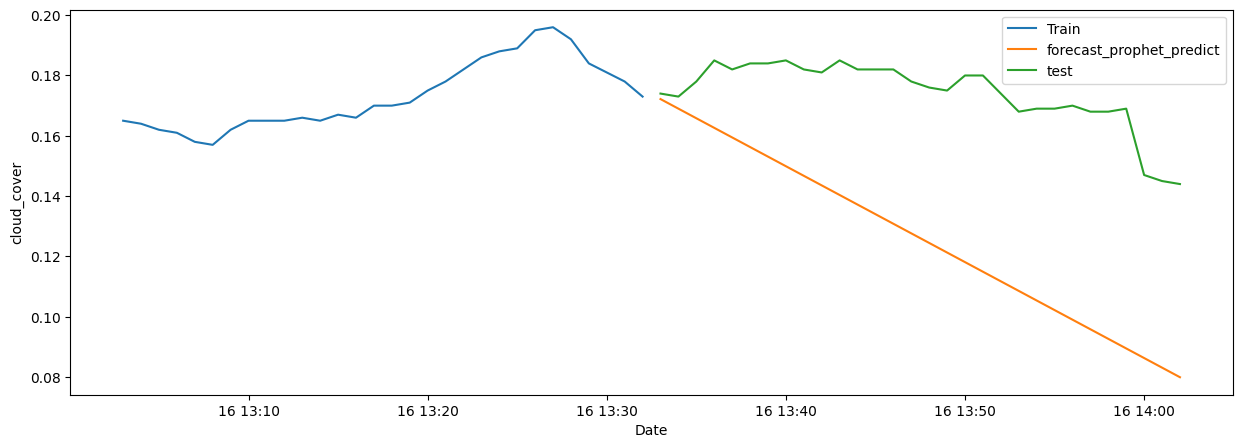

In [50]:
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('cloud_cover')
sns.lineplot(x= train_pr['ds'], y=train_pr["y"],label = 'Train') 
sns.lineplot(x=fcast['ds'], y = fcast["yhat"], label = 'forecast_prophet_predict')
sns.lineplot(x=test_pr2['ds'], y = test_pr2["y"], label = 'test')
# sns.lineplot(x=forecast_pro['ds'], y = forecast_pro["yhat"], color = 'blue', label = 'forecast_prophet_predict_test')

### forecasting with 20 minutes ไม่ใช้ข้อมูล20ก่อนหน้ามาpredict

In [51]:
model_pro_mi = Prophet()
model_pro_mi.fit(df)

16:51:26 - cmdstanpy - INFO - Chain [1] start processing
16:51:50 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
fcast2= model_pro_mi.predict(df_index_20_min)
forecast_20 = fcast2[['ds','yhat']]
forecast_20

,ds,yhat
0,2021-12-16 14:02:00,0.180910
1,2021-12-16 14:03:00,0.179880
2,2021-12-16 14:04:00,0.178845
3,2021-12-16 14:05:00,0.177805
4,2021-12-16 14:06:00,0.176761
5,2021-12-16 14:07:00,0.175713
6,2021-12-16 14:08:00,0.174660
7,2021-12-16 14:09:00,0.173605
8,2021-12-16 14:10:00,0.172546
9,2021-12-16 14:11:00,0.171484


In [53]:
fcast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-16 14:02:00,0.058014,-0.102167,0.444397,0.058014,0.058014,0.122896,0.122896,0.122896,0.200281,0.200281,0.200281,-0.077385,-0.077385,-0.077385,0.0,0.0,0.0,0.180910
1,2021-12-16 14:03:00,0.057988,-0.101184,0.460190,0.057988,0.057988,0.121892,0.121892,0.121892,0.199134,0.199134,0.199134,-0.077242,-0.077242,-0.077242,0.0,0.0,0.0,0.179880
2,2021-12-16 14:04:00,0.057962,-0.089456,0.438641,0.057962,0.057962,0.120883,0.120883,0.120883,0.197982,0.197982,0.197982,-0.077099,-0.077099,-0.077099,0.0,0.0,0.0,0.178845
3,2021-12-16 14:05:00,0.057936,-0.096253,0.449430,0.057936,0.057936,0.119870,0.119870,0.119870,0.196826,0.196826,0.196826,-0.076956,-0.076956,-0.076956,0.0,0.0,0.0,0.177805
4,2021-12-16 14:06:00,0.057910,-0.109421,0.454548,0.057910,0.057910,0.118852,0.118852,0.118852,0.195665,0.195665,0.195665,-0.076813,-0.076813,-0.076813,0.0,0.0,0.0,0.176761
5,2021-12-16 14:07:00,0.057883,-0.099285,0.460541,0.057883,0.057883,0.117829,0.117829,0.117829,0.194500,0.194500,0.194500,-0.076670,-0.076670,-0.076670,0.0,0.0,0.0,0.175713
6,2021-12-16 14:08:00,0.057857,-0.125359,0.443061,0.057857,0.057857,0.116803,0.116803,0.116803,0.193331,0.193331,0.193331,-0.076528,-0.076528,-0.076528,0.0,0.0,0.0,0.174660
7,2021-12-16 14:09:00,0.057831,-0.097201,0.451398,0.057831,0.057831,0.115773,0.115773,0.115773,0.192158,0.192158,0.192158,-0.076385,-0.076385,-0.076385,0.0,0.0,0.0,0.173605
8,2021-12-16 14:10:00,0.057805,-0.097890,0.437477,0.057805,0.057805,0.114740,0.114740,0.114740,0.190983,0.190983,0.190983,-0.076242,-0.076242,-0.076242,0.0,0.0,0.0,0.172546
9,2021-12-16 14:11:00,0.057779,-0.101538,0.445300,0.057779,0.057779,0.113705,0.113705,0.113705,0.189805,0.189805,0.189805,-0.076100,-0.076100,-0.076100,0.0,0.0,0.0,0.171484


### forecasting with 30 minutes by dataset 30 minutes ago

In [54]:
model_pro_mi3 = Prophet()
model_pro_mi3.fit(X_test)

16:51:51 - cmdstanpy - INFO - Chain [1] start processing
16:51:51 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
fcast3= model_pro_mi3.predict(df_index_30_min)
forecast_30 = fcast3[['ds','yhat']]
forecast_30

,ds,yhat
0,2021-12-16 14:02:00,0.149676
1,2021-12-16 14:03:00,0.146786
2,2021-12-16 14:04:00,0.143896
3,2021-12-16 14:05:00,0.141006
4,2021-12-16 14:06:00,0.138116
5,2021-12-16 14:07:00,0.135226
6,2021-12-16 14:08:00,0.132336
7,2021-12-16 14:09:00,0.129446
8,2021-12-16 14:10:00,0.126556
9,2021-12-16 14:11:00,0.123666


<AxesSubplot: xlabel='Date', ylabel='cloud_cover'>

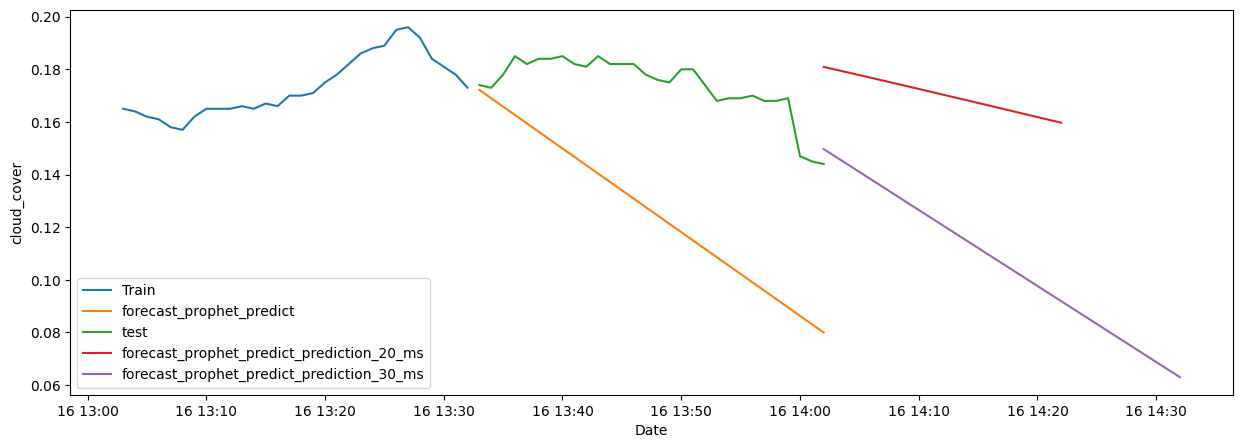

In [56]:
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('cloud_cover')
sns.lineplot(x= train_pr['ds'], y=train_pr["y"],label = 'Train') 
sns.lineplot(x=fcast['ds'], y = fcast["yhat"], label = 'forecast_prophet_predict')
sns.lineplot(x=test_pr2['ds'], y = test_pr2["y"], label = 'test')
# sns.lineplot(x=forecast_pro['ds'], y = forecast_pro["yhat"], color = 'blue', label = 'forecast_prophet_predict_test')
sns.lineplot(x=forecast_20['ds'], y =forecast_20["yhat"], label = 'forecast_prophet_predict_prediction_20_ms')
sns.lineplot(x=forecast_30['ds'], y =forecast_30["yhat"], label = 'forecast_prophet_predict_prediction_30_ms')

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines', x= train_pr2['ds'], y=train_pr2["y"], name='Train'))
fig.add_trace(go.Scatter(mode='lines', x=fcast['ds'], y = fcast["yhat"], name='forecast_prophet_predict'))
fig.add_trace(go.Scatter(mode='lines', x=test_pr2['ds'], y = test_pr2["y"], name='test'))
fig.add_trace(go.Scatter(mode='lines', x=df['ds'], y = df["y"],  name='forecast_prophet_predict_compare_test'))
fig.add_trace(go.Scatter(mode='lines', x=forecast_20['ds'], y =forecast_20["yhat"],  name='forecast_prophet_predict_prediction_20_ms'))
fig.add_trace(go.Scatter(mode='lines', x=forecast_30['ds'], y =forecast_30["yhat"],  name='forecast_prophet_predict_prediction_30_ms'))

fig.update_layout(
    autosize=True,
    height=600,
    title="Prophet Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

# Evaluating forecast accuracy

- **MAE** ย่อมาจาก Mean Absolute Error หรือเรียกอีกชื่อหนึ่งว่า L1 Loss ค่า MAE นี้ชื่อก็บอกอยู่แล้วว่าใช้ Absolute มาช่วยทำให้ค่า Error กลายเป็นบวก สูตรคำนวนจึงเป็นการนำค่า Error มาใส่ Absolute ก่อนที่จะนำมาหาค่าเฉลี่ยของ Error
- **MSE** ย่อมาจาก Mean Square Error หรือเรียกอีกชื่อหนึ่งว่า L2 Loss เช่นเดียวกัน ค่า MSE จะมีการทำให้ค่า Error กลายเป็นบวกก่อนโดยการนำค่า Error มายกกำลังสอง ก่อนที่จะนำค่า Error มาหาค่าเฉลี่ย
- **RMSE** ย่อมาจาก Root Mean Square Error เป็น Loss Function ที่จะนำค่า MSE มาใส่ Square Root จึงทำให้มีคุณสมบัติที่คล้ายกับค่า MSE แต่ต่างกันตรงที่ หน่วยของค่า Error จะไม่มีเลขยกกำลังสอง จึงทำให้อ่านค่าได้ง่ายกว่า เนื่องจากหน่วยของ RMSE นั้นมีหน่วยเดียวกันกับค่าที่โมเดลทำนายไว้

In [58]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [59]:
prophet_mse_error = mean_squared_error(test_pr2["y"], fcast["yhat"], squared=True)
prophet_rmse_error = mean_squared_error(test_pr2["y"], fcast["yhat"], squared=False)
prophet_mae_error = mean_absolute_error(test_pr2["y"], fcast["yhat"])

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMAE: {prophet_mae_error}')

MSE Error: 0.002719789773283801
RMSE Error: 0.05215160374603835
MAE: 0.04790164875941318


In [60]:
prophet_r2 = r2_score(test_pr2["y"], fcast["yhat"])
print(f'r2_score: {prophet_r2}')

r2_score: -20.98718030302456
